In [1]:
!pip install pytorch-fid
!pip install wget
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=97e3249e22f5710b28125c5d7437952d5136dbeb231df4389a30b0f6d7362250
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c711be04857ffa6bafa97716a8447d0166df0db8e3a0984f27bd697d3e50597a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import shutil
import cupy as cp
import numpy
import math
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.autograd import Variable
from pytorch_fid import inception
from torchvision.models.inception import inception_v3
from PIL import Image
from scipy import linalg
from scipy.stats import entropy
import wget

In [3]:
os.mkdir('unfiltered')
data_path = r'./unfiltered'
os.mkdir('filtered')
target_path= r'./filtered'
os.mkdir('examples')
os.mkdir('trained_models')

In [4]:
URL = "https://drive.google.com/u/0/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t" 
!wget -O thecarconnectionpicturedataset.rar --no-check-certificate "$URL"

--2022-05-25 19:01:25--  https://drive.google.com/u/0/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.142.100, 74.125.142.139, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t [following]
--2022-05-25 19:01:25--  https://drive.google.com/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1hb1i207da3img5fjlj24dkgcbala14o/1653505275000/01153971418670501229/*/1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD?e=download [following]
--2022-05-25 19:01:25--  https://doc-0o-70-docs.googleusercontent.com/docs/secur

In [5]:
!unrar x "thecarconnectionpicturedataset.rar" "unfiltered/"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_FKQ.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_GGR.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_GWL.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_IiW.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_iTX.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_jdQ.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_JFf.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_jpO.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_1

In [6]:
listOfFiles = os.listdir(data_path)
car_types= ['Convertible','Pickup','Station Wagon','4dr','3dr','2dr','SUV','Van']  # reszta to 'nan'
car_dictionary = dict.fromkeys(car_types)
for type_of_car in car_types:
    str_match = [s for s in listOfFiles if type_of_car+"_" in s]
    car_dictionary[type_of_car] = len(str_match)
    # ponizej tworzenie folderow z posortowanymi juz zdjeciami typow, czyli tzw. klas
    os.mkdir(os.path.join(target_path,type_of_car))
    target_dir = os.path.join(target_path,type_of_car)
    for fname in str_match:
        # przenoszenie plikow do wlasciwych folderow
        shutil.move(os.path.join(data_path,fname), target_dir)

In [7]:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

cuda

True

In [52]:
## inicjalizacja parametrow
number_of_classes = len(car_types)
number_of_epochs = 6

image_size_width = 320
image_size_height = 200

image_size_width = 250
image_size_height = 250

image_size=(image_size_width,image_size_height)
channels = 3 # RGB
img_shape_tuple = (channels, image_size_width, image_size_height)
img_shape = cp.array([channels, image_size_width, image_size_height])

batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent_size = 128  # rozmiar wektora wejsciowego do generatora

# rozmiar zdjec 320x213 pikseli, niektore na x240 lub x160 piskeli, dlatego niech bedzie 320x200 krakowskim targiem
# no chyba że musimy mieć kwadrat, jest tak podanych wiele przykladow i nie wiem, 
# czy przypadkiem wtedy nie ma siec latwiej sobie podzielic obrazu jesli oba rozmiary sa rowne

# z czego korzystam?
# 1) https://jovian.ai/tvscitechtalk/car-gan
# 2) https://github.com/ozanciga/gans-with-pytorch/blob/master/cgan/cgan.py

# ten poniżej kod bardziej do mnie przemawia jeśli chodzi o definicje dyskryminatora i generatora
# 3) https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cgan/cgan.py#L189

# konwersja obrazu do tensora z odpowiednimi warunkami 
train_ds = ImageFolder(target_path, transform=T.Compose([
    T.Resize((image_size_width,image_size_height)),
    T.ToTensor(),
    T.Normalize(*stats)]))

## wykorzystanie części zbioru
train_ds.samples = [train_ds.samples[idx] for idx in range(5000)]
train_ds.targets = [train_ds.targets[idx] for idx in range(5000)]

# zbiór treningowy
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


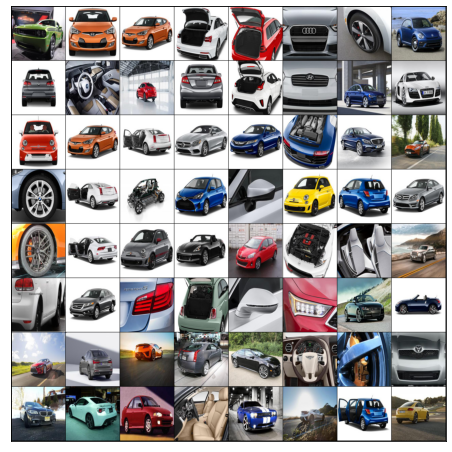

In [43]:
## pokazanie przykladowego batcha ze zdjeciami samochodow

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [53]:
## klasa generatora

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(number_of_classes, number_of_classes,device=torch.device('cuda'))

        def block(in_feat, out_feat, normalize=True):
                # layers = [nn.Linear(in_feat, out_feat)]
                layers = [nn.Linear(in_feat, out_feat)]
                if normalize:
                    layers.append(nn.BatchNorm1d(out_feat, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

        self.model = nn.Sequential(
            # nn.Linear(latent_size + number_of_classes, 128),
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Linear(128, 256),
            # nn.BatchNorm1d(256, 0.5),
            # nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(latent_size + number_of_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(cp.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input.cuda())
        img = img.view(img.size(0), *img_shape_tuple)
        return img

In [58]:
## klasa dyskryminatora - póki co idea skopiowana z linku 3)
class Discriminator(nn.Module):
    def __init__(self):
            super(Discriminator, self).__init__()

            self.label_emb = nn.Embedding(number_of_classes, number_of_classes,device=torch.device('cuda'))

            # self.model = nn.Sequential(
                
            #     nn.Conv2d(3, 250, kernel_size=5, stride=10, padding=1, bias=False),
            #     nn.BatchNorm2d(250),
            #     nn.LeakyReLU(0.2, inplace=True),
                
                
            #     nn.Conv2d(250, 500, kernel_size=5, stride=10, padding=1, bias=False),
            #     nn.BatchNorm2d(500),
            #     nn.LeakyReLU(0.2, inplace=True),
              
            #     nn.Conv2d(500, 1, kernel_size=5, stride=10, padding=0, bias=False), 

            # #     # nn.Conv2d(1000, 2000, kernel_size=5, stride=2, padding=1, bias=False),
            # #     # nn.BatchNorm2d(2000),
            # #     # nn.LeakyReLU(0.2, inplace=True),
                

            # #     # nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # #     # # nn.BatchNorm2d(512),
            # #     # nn.LeakyReLU(0.2, inplace=True),
            # #     # # out: 512 x 4 x 4

            # #     # nn.Conv2d(2000, 1, kernel_size=5, stride=1, padding=0, bias=False),               

            #     nn.Flatten(),
            #     nn.Sigmoid()
            # )

            self.model = nn.Sequential(
                nn.Linear(number_of_classes+ int(cp.prod(img_shape)), 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 512),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 512),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 1),
                nn.Sigmoid()
            )

            # self.model = nn.Sequential(
            #     nn.Linear(number_of_classes+ int(cp.prod(img_shape)), 1024),
            #     nn.LeakyReLU(0.4, inplace=True),
            #     nn.Linear(1024, 512),
            #     nn.Dropout(0.4),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     nn.Linear(512, 512),
            #     nn.Dropout(0.4),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     nn.Linear(512, 256),
            #     nn.Dropout(0.4),
            #     # nn.LeakyReLU(0.2, inplace=True),
            #     # nn.Linear(256, 256),
            #     # nn.Dropout(0.4),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     nn.Linear(256, 1),
            #     nn.Sigmoid()
            # )

            self.embe= nn.Sequential(
            nn.Linear(8, 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(4, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2, 1)
            )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        # print(self.label_emb(labels).size())
        # print(type(self.label_emb(labels)))
      
        # embe_linear=self.embe(self.label_emb(labels).cuda())
        # print(embe_linear.size())

        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        # # d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        # # d_n = d_in.view(1,d_in.size(0), d_in.size(1),1)
        # # print(d_n.size())
        # # d_n = d_in.view(d_in.size(0), d_in.size(1),1)
        # # print(d_n.size())
        # # d_n = d_in.view(1,1,d_in.size(0), d_in.size(1))
        # d_n = img.view(batch_size,3,250, 250)
        # print(d_n.size())
        # # validity = self.model(d_in.view(d_in.size(0), d_in.size(1), 1, 1))
        # validity = self.model(d_n)
        return validity

In [59]:
# jako funkcja straty binarna entropia krzyzowa
fun_loss = nn.BCELoss()

device=torch.device('cuda')
# inicjalizacja generatora i dyskyminatora
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# wykorzystanie algorytmu Adam do optymalizacji procesu uczenia metodą spadku gradientu
b1=0.5
b2=0.999
lrate=0.0002
#lrate=0.0005
optimizer_D = optim.Adam(discriminator.parameters(), lr=lrate, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=lrate, betas=(b1, b2))

In [60]:
def sample_image(n_row, batches_done):
    """zapisywanie obrazów wygenerowanych przez klasę generatora"""
    # losowy szum
    z = Variable(FloatTensor(cp.random.normal(0, 1, (n_row ** 2, latent_size))))
    # przygotowanie etykiet klas
    labels = cp.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    # wygenerowanie obrazow
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "./examples/%d.png" % batches_done, nrow=n_row, normalize=True)

In [61]:
# ----------
#  Training
# ----------
d_loss_it=[]
g_loss_it=[]

for epoch in range(number_of_epochs):
    for i, (imgs, labels) in enumerate(train_dl):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(cp.random.normal(0, 1, (batch_size, latent_size))))
        gen_labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = fun_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = fun_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = fun_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch + 1, number_of_epochs, i + 1, len(train_dl), d_loss.item(), g_loss.item())
        )

        d_loss_it.append(d_loss.item())
        g_loss_it.append(g_loss.item())

        batches_done = epoch * len(train_dl) + i
        if batches_done % 20 == 0:
            sample_image(n_row=5, batches_done=batches_done)


torch.cuda.empty_cache()

[Epoch 1/6] [Batch 1/40] [D loss: 0.705293] [G loss: 0.722443]
[Epoch 1/6] [Batch 2/40] [D loss: 0.611266] [G loss: 0.715252]
[Epoch 1/6] [Batch 3/40] [D loss: 0.425402] [G loss: 0.571474]
[Epoch 1/6] [Batch 4/40] [D loss: 0.306042] [G loss: 1.057742]
[Epoch 1/6] [Batch 5/40] [D loss: 0.703020] [G loss: 0.294414]
[Epoch 1/6] [Batch 6/40] [D loss: 0.190368] [G loss: 1.386949]
[Epoch 1/6] [Batch 7/40] [D loss: 1.195958] [G loss: 1.704827]
[Epoch 1/6] [Batch 8/40] [D loss: 9.336444] [G loss: 0.000052]
[Epoch 1/6] [Batch 9/40] [D loss: 2.874892] [G loss: 0.007573]
[Epoch 1/6] [Batch 10/40] [D loss: 0.312495] [G loss: 0.874586]
[Epoch 1/6] [Batch 11/40] [D loss: 2.430069] [G loss: 2.714922]
[Epoch 1/6] [Batch 12/40] [D loss: 0.555941] [G loss: 0.402425]
[Epoch 1/6] [Batch 13/40] [D loss: 0.517419] [G loss: 0.449769]
[Epoch 1/6] [Batch 14/40] [D loss: 0.457577] [G loss: 0.552060]
[Epoch 1/6] [Batch 15/40] [D loss: 0.412944] [G loss: 0.580503]
[Epoch 1/6] [Batch 16/40] [D loss: 0.233954] [G l

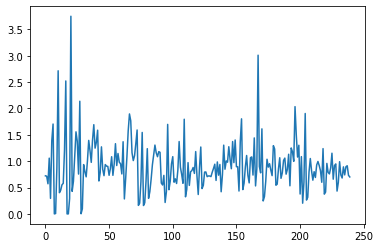

In [63]:
torch.cuda.empty_cache()
plt.plot(g_loss_it)
plt.plot(d_loss_it)

In [ ]:
# Save trained model (optional)
torch.save(generator.state_dict(), './trained_models/generator.pt')

In [ ]:
# Load previously trained model (optional)
generator = Generator().to(device)
generator.load_state_dict(torch.load('./trained_models/generator.pt'))
generator.eval()

Generator(
  (label_emb): Embedding(8, 8)
  (model): Sequential(
    (0): Linear(in_features=136, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=192000, bias=True)
    (12): Tanh()
  )
)

In [64]:
# Generate & save an example of every class
classes = Variable(LongTensor(range(len(car_types))))
noise = Variable(FloatTensor(cp.random.normal(0, 1, (len(car_types), latent_size))))
gen_imgs = generator(noise, classes)
save_image(gen_imgs.data, "./examples/final.png", normalize=True)

In [18]:
# Caclulate FID

######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = numpy.mean(distribution_1, axis=0)
    sigma1 = numpy.cov(distribution_1, rowvar=False)

    mu2 = numpy.mean(distribution_2, axis=0)
    sigma2 = numpy.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = numpy.atleast_1d(mu1)
    mu2 = numpy.atleast_1d(mu2)

    sigma1 = numpy.atleast_2d(sigma1)
    sigma2 = numpy.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not numpy.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = numpy.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if numpy.iscomplexobj(covmean):
        if not numpy.allclose(numpy.diagonal(covmean).imag, 0, atol=1e-3):
            m = numpy.max(numpy.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = numpy.trace(covmean)

    return (diff.dot(diff) + numpy.trace(sigma1) +
            numpy.trace(sigma2) - 2 * tr_covmean)

dims = 2048 # ile wyjsc fragmentu sieci z InceptionV3
block_idx = inception.InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = inception.InceptionV3([block_idx]).to(device)

noise = Variable(FloatTensor(cp.random.normal(0, 1, (30, latent_size))))
labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, 30)))
generated_imgs = generator(noise, labels)

loader = DataLoader(train_ds, 30, shuffle=True)
orig_imgs, orig_labels = iter(loader).next()
generated_dist = model(generated_imgs)[0]
orig_dist = model(orig_imgs.to(device))[0]
orig_dist = orig_dist.cpu()
generated_dist = generated_dist.cpu()
fid = calculate_frechet_distance(orig_dist.squeeze().detach().numpy(), 
                                generated_dist.squeeze().detach().numpy())

print(f'Frechet Inception Distance score: {fid}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

Frechet Inception Distance score: 163.62047318734818


In [50]:
# torch.cuda.empty_cache()
variables = discriminator,optimizer_G,optimizer_D
import gc
del variables
gc.collect()

1996

In [27]:
# Caclulate IS
######### Inception Score based on implementation from https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py

def inception_score(imgs, cuda=True, batch_size=30, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # # Load inception model
    model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    model.eval();

    #model = inception.InceptionV3(pretrained=True, transform_input=False).type(dtype)
    # dims = 2048
    # block_idx = inception.InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    # model = inception.InceptionV3([block_idx]).to(device)

    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = model(x)
        print(type(x))
        return nn.functional.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = numpy.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = numpy.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(numpy.exp(numpy.mean(scores)))

    return numpy.mean(split_scores), numpy.std(split_scores)

noise = Variable(FloatTensor(cp.random.normal(0, 1, (30, latent_size))))
labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, 30)))
generated_imgs = generator(noise, labels)

print ("Calculating Inception Score...")
print (inception_score(generated_imgs, cuda=True, batch_size=20, resize=True, splits=5))

# loader = DataLoader(train_ds, 30, shuffle=True)
# orig_imgs, orig_labels = iter(loader).next()
# generated_dist = model(generated_imgs)[0]
# orig_dist = model(orig_imgs.to(device))[0]
# orig_dist = orig_dist.cpu()
# generated_dist = generated_dist.cpu()
# fid = calculate_frechet_distance(orig_dist.squeeze().detach().numpy(), 
#                                 generated_dist.squeeze().detach().numpy())


Calculating Inception Score...


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
(2.5535254891643246, 0.25815975467757163)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
